[Link a la carpeta con todo el TP](https://drive.google.com/drive/u/0/folders/1do-iyf2SzQln-fh8tmu9mSfzLuim5xs5)

# Imports y obtención de archivos

In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from category_encoders import TargetEncoder
import seaborn as sns
import gc

from google.colab.patches import cv2_imshow
import cv2

pd.options.display.float_format = '{:20,.10f}'.format

import warnings
warnings.filterwarnings('ignore')

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
if not os.path.exists('train.parq'):
  id1="1Tf5pfrYBk8yM6QzC5IWebtSlja3R5BwN"
  downloaded1 = drive.CreateFile({'id': id1})
  downloaded1.GetContentFile('train.parq')

# Inicializar dfs

In [6]:
raw_train = pq.read_table('train.parq').to_pandas()
raw_train['ct'] = 1

In [7]:
raw_train.columns

Index(['attack_time', 'watcher_country', 'watcher_as_num', 'watcher_as_name',
       'attacker_country', 'attacker_as_num', 'attacker_as_name',
       'attack_type', 'watcher_uuid_enum', 'attacker_ip_enum', 'label', 'ct'],
      dtype='object')

# Plot 1/6: ataques por tipo

In [ ]:
plot1_df = raw_train[['attack_type', 'label']]
plot1_df = plot1_df.groupby('attack_type')['label'].mean().reset_index()

In [ ]:
plot1_df.sample(5)

,attack_type,label
4,http:exploit,0.0200829118
2,http:bruteforce,0.0130407510
0,database:bruteforce,0.0000000000
11,tcp:scan,0.0002149587
6,http:spam,0.0183617831


<function matplotlib.pyplot.show(close=None, block=None)>

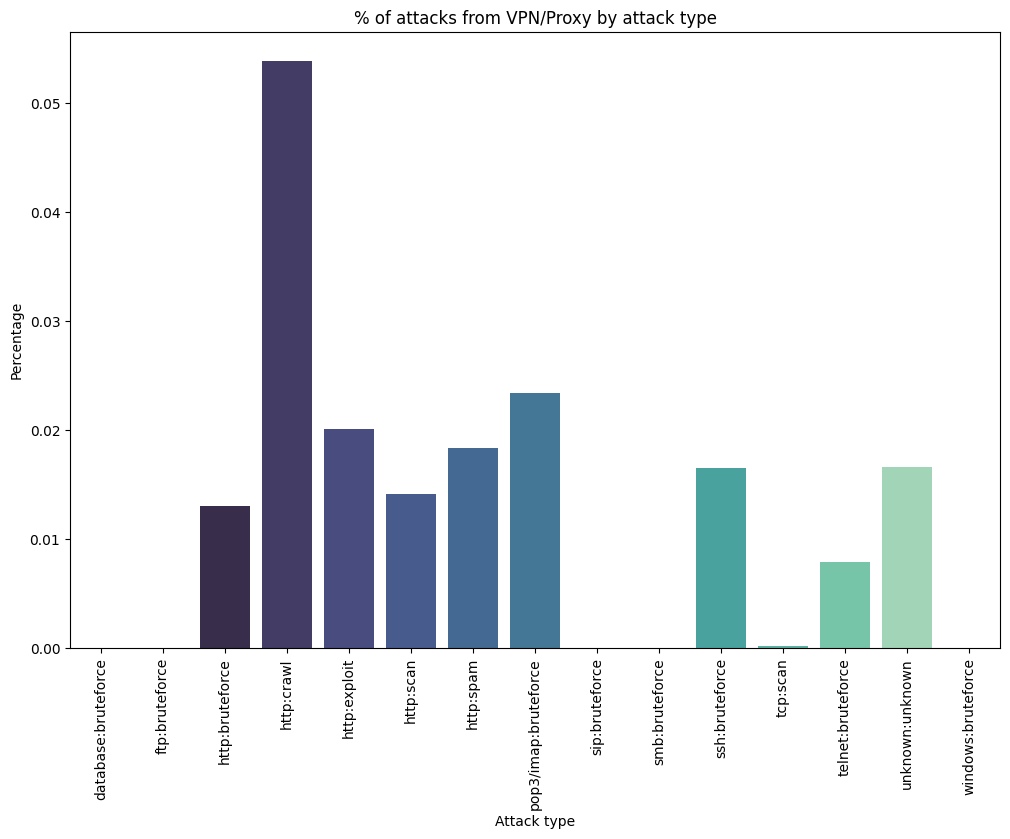

In [ ]:
f, ax1 = plt.subplots(figsize=(12,8))

sns.barplot(plot1_df,
            x='attack_type',
            y='label',
            log=False,
            palette='mako',
            ax=ax1
            )

ax1.set_title("% of attacks from VPN/Proxy by attack type")
ax1.set_xlabel("Attack type")
plt.xticks(rotation=90)
ax1.set_ylabel("Percentage")

f.savefig('visu1.png', dpi=200)

plt.show

In [ ]:
del plot1_df
gc.collect()

30

## Insights

---

- Hay un claro outlier, `http:crawl`
- De todos los bruteforce, los únicos que tienen porcentaje a tener en cuenta son ssh, http, y pop3/imap (y http parece que va más por el lado de ser http que ser bruteforce)
- En conclusión, parece útil saber las cosas por separado (sobre todo http que tiene chances más altas y bruteforce que tiene chances más bajas), pero tener la conjunta sirve para las excepciones (i.e. `ssh:bruteforce`)
- For the record, intenté usar este de plot 2D/heatmap, pero no queda un buen plot (queda la mayoría de as combinaciones vacías). Los ví los dos juntos y este es definitivamente más fácil de interpretar


# Plot 2/6: heatmap de continentes

In [ ]:
continents = {
    'US': 'NA', 'DE': 'EU', 'SG': 'AS', 'CN': 'AS', 'NL': 'EU', 'GI': 'EU',
    'FR': 'EU', 'IN': 'AS', 'GB': 'EU', 'RU': 'EU', 'CA': 'NA', 'GM': 'AF',
    'VN': 'AS', 'BR': 'SA', 'ID': 'AS', 'HK': 'AS', 'IT': 'EU', 'GN': 'AF',
    'AU': 'OC', 'JP': 'AS', 'KR': 'AS', 'UA': 'EU', 'SE': 'EU', 'GP': 'NA',
    'FI': 'EU', 'BG': 'EU', 'IR': 'AS', 'TR': 'AS', 'BD': 'AS', 'PH': 'AS',
    'ES': 'EU', 'SK': 'EU', 'TH': 'AS', 'PL': 'EU', 'AR': 'SA', 'GQ': 'AF',
    'LU': 'EU', 'CH': 'EU', 'PK': 'AS', 'MX': 'NA', 'RO': 'EU', 'GU': 'NA',
    'ZA': 'AF', 'BE': 'EU', 'NO': 'EU', 'RS': 'EU', 'TW': 'AS', 'GY': 'SA',
    'AT': 'EU', 'AE': 'AS', 'LV': 'EU', 'MY': 'AS', 'PT': 'EU', 'KM': 'AF',
    'CZ': 'EU', 'CO': 'SA', 'AZ': 'AS', 'DK': 'EU', 'LT': 'EU', 'LC': 'NA',
    'IL': 'AS', 'KH': 'AS', 'IE': 'EU', 'GR': 'EU', 'VE': 'SA', 'ML': 'AF',
    'PE': 'SA', 'SA': 'AS', 'KE': 'AF', 'CL': 'SA', 'BF': 'AF', 'MW': 'AF',
    'MA': 'AF', 'MD': 'EU', 'CI': 'AF', 'MN': 'AS', 'HR': 'EU', 'NA': 'AF',
    'KZ': 'AS', 'EG': 'AF', 'ET': 'AF', 'MC': 'EU', 'MU': 'AF', 'RE': 'AF',
    'TN': 'AF', 'DO': 'NA', 'NP': 'AS', 'PA': 'CA', 'BM': 'NA', 'SD': 'AF',
    'GH': 'AF', 'HU': 'EU', 'EE': 'EU', 'BY': 'EU', 'BA': 'EU', 'SX': 'NA',
    'DZ': 'AF', 'MK': 'EU', 'GE': 'AS', 'EC': 'SA', 'IQ': 'AS', 'TC': 'NA',
    'LK': 'AS', 'NG': 'AF', 'AM': 'EU', 'AL': 'EU', 'BW': 'AF', 'YE': 'AS',
    'LB': 'AS', 'AO': 'AF', 'NZ': 'OC', 'JO': 'AS', 'BO': 'SA', 'NC': 'OC',
    'TZ': 'AF', 'PY': 'SA', 'GT': 'CA', 'HN': 'CA', 'BN': 'AS', 'SM': 'EU',
    'MZ': 'AF', 'UZ': 'AS', 'QA': 'AS', 'CY': 'EU', 'LA': 'AS', 'SI': 'EU',
    'OM': 'AS', 'KW': 'AS', 'UG': 'AF', 'ME': 'EU', 'SV': 'CA',
    'JM': 'NA', 'BH': 'AS', 'UY': 'SA', 'BB': 'NA', 'BQ': 'SA',
    'RW': 'AF', 'PF': 'OC', 'CR': 'CA', 'MV': 'AS', 'PS': 'AS',
    'LY': 'AF', 'SN': 'AF', 'ZW': 'AF', 'TT': 'NA', 'XK': 'EU',
    'IS': 'EU', 'MT': 'EU', 'MM': 'AS', 'KG': 'AS', 'BI': 'AF', 'LI': 'EU',
    'WS': 'OC', 'BZ': 'CA', 'PR': 'NA', 'TG': 'AF', 'BS': 'NA',
    'NI': 'CA', 'SC': 'AF', 'ZM': 'AF', 'CM': 'AF', 'MR': 'AF',
    'VG': 'NA', 'CW': 'NA', 'SO': 'AF', 'MG': 'AF', 'DM': 'NA',
    'AF': 'AS', 'SY': 'AS', 'CD': 'AF', 'CV': 'AF', 'SS': 'AF', 'AG': 'NA',
    'SR': 'SA', 'TJ': 'AS', 'HT': 'NA', 'BJ': 'AF', 'AD': 'EU',
    'DJ': 'AF', 'IM': 'EU', 'MO': 'AS', 'GG': 'EU', 'GF': 'SA',
    'BT': 'AS', 'ER': 'AF', 'NE': 'AF', 'FO': 'EU', 'GD': 'NA',
    'SB': 'OC', 'SZ': 'AF', 'KN': 'NA', 'KY': 'NA', 'FM': 'OC',
    'LS': 'AF', 'VC': 'NA', 'CX': 'OC', 'GW': 'AF', 'PG': 'OC',
    'PM': 'NA', 'GL': 'NA', 'SH': 'AF', 'ST': 'AF', 'GA': 'AF',
    'VI': 'NA', 'LR': 'AF', 'TL': 'AS', 'CG': 'AF', 'MP': 'OC',
    'KP': 'AS', 'CU': 'CA', 'AI': 'NA', 'SL': 'AF', 'AW': 'NA',
    'FJ': 'OC', 'MQ': 'NA', 'JE': 'EU', 'GG': 'EU'
}

In [ ]:
plot2_df = raw_train[['attacker_country', 'watcher_country', 'label']]
plot2_df['watcher_country'] = plot2_df['watcher_country'].apply(lambda x: continents[x]).astype('category')
plot2_df['attacker_country'] = plot2_df['attacker_country'].apply(lambda x: continents[x]).astype('category')



In [ ]:
plot2_df = plot2_df.groupby(['attacker_country', 'watcher_country'])['label'].mean().unstack()

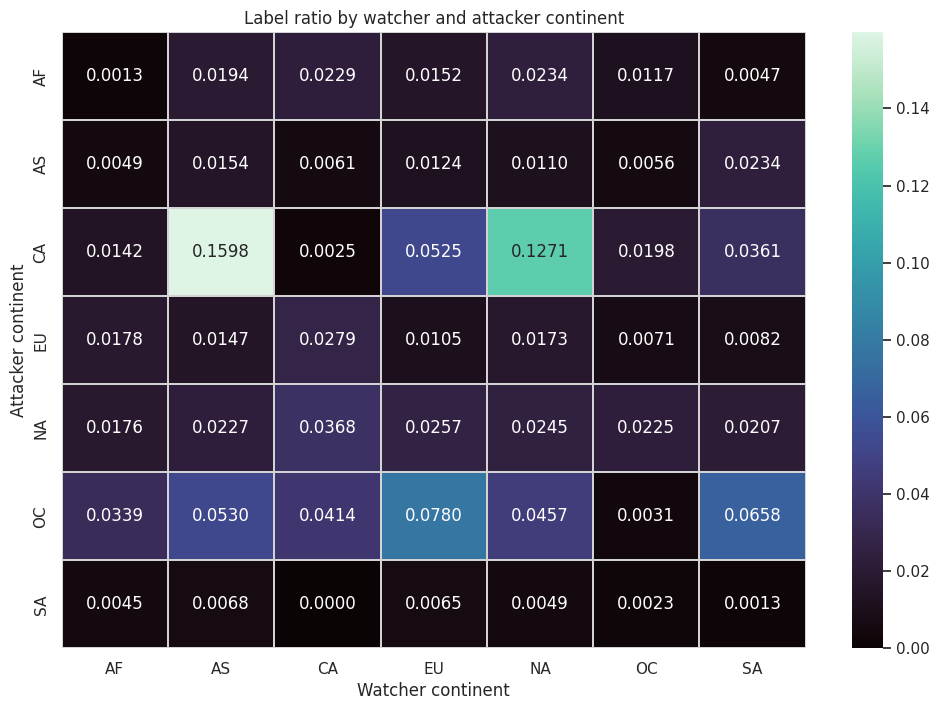

In [ ]:
f, ax2 = plt.subplots(figsize=(12,8))

plt.style.use('default')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format

sns.heatmap(plot2_df,
            cmap="mako",
            linewidths=0.05,
            linecolor='lightgray',
            annot=True,
            ax=ax2,
            fmt='.4f'
            )

ax2.set_title("Label ratio by watcher and attacker continent")
ax2.set_xlabel("Watcher continent")
ax2.set_ylabel("Attacker continent")
ax2.set_facecolor('darkslategrey')
ax2.grid(False)

f.savefig('visu2.png', dpi=200)

In [ ]:
del plot2_df, continents
gc.collect()

5692

### Insights
---
- Esta fue la mejor forma que se me ocurrió de hacer un plot con los países que fuera medianamente legible (son demasiados países para plotearlos por separado)
- Lo más notable es que los valores en la diagonal (attacker y watcher en el mismo continente) son bajos, por lo que los ataques de un país a un watcher en ese mismo país también deben ser raros.
- Más abajo están las marginales, no hallé manera de hacer el 2d con marginales usando categóricas

# Plot 3: 2d

In [ ]:
continents = {
    'US': 'NA', 'DE': 'EU', 'SG': 'AS', 'CN': 'AS', 'NL': 'EU', 'GI': 'EU',
    'FR': 'EU', 'IN': 'AS', 'GB': 'EU', 'RU': 'EU', 'CA': 'NA', 'GM': 'AF',
    'VN': 'AS', 'BR': 'SA', 'ID': 'AS', 'HK': 'AS', 'IT': 'EU', 'GN': 'AF',
    'AU': 'OC', 'JP': 'AS', 'KR': 'AS', 'UA': 'EU', 'SE': 'EU', 'GP': 'NA',
    'FI': 'EU', 'BG': 'EU', 'IR': 'AS', 'TR': 'AS', 'BD': 'AS', 'PH': 'AS',
    'ES': 'EU', 'SK': 'EU', 'TH': 'AS', 'PL': 'EU', 'AR': 'SA', 'GQ': 'AF',
    'LU': 'EU', 'CH': 'EU', 'PK': 'AS', 'MX': 'NA', 'RO': 'EU', 'GU': 'NA',
    'ZA': 'AF', 'BE': 'EU', 'NO': 'EU', 'RS': 'EU', 'TW': 'AS', 'GY': 'SA',
    'AT': 'EU', 'AE': 'AS', 'LV': 'EU', 'MY': 'AS', 'PT': 'EU', 'KM': 'AF',
    'CZ': 'EU', 'CO': 'SA', 'AZ': 'AS', 'DK': 'EU', 'LT': 'EU', 'LC': 'NA',
    'IL': 'AS', 'KH': 'AS', 'IE': 'EU', 'GR': 'EU', 'VE': 'SA', 'ML': 'AF',
    'PE': 'SA', 'SA': 'AS', 'KE': 'AF', 'CL': 'SA', 'BF': 'AF', 'MW': 'AF',
    'MA': 'AF', 'MD': 'EU', 'CI': 'AF', 'MN': 'AS', 'HR': 'EU', 'NA': 'AF',
    'KZ': 'AS', 'EG': 'AF', 'ET': 'AF', 'MC': 'EU', 'MU': 'AF', 'RE': 'AF',
    'TN': 'AF', 'DO': 'NA', 'NP': 'AS', 'PA': 'CA', 'BM': 'NA', 'SD': 'AF',
    'GH': 'AF', 'HU': 'EU', 'EE': 'EU', 'BY': 'EU', 'BA': 'EU', 'SX': 'NA',
    'DZ': 'AF', 'MK': 'EU', 'GE': 'AS', 'EC': 'SA', 'IQ': 'AS', 'TC': 'NA',
    'LK': 'AS', 'NG': 'AF', 'AM': 'EU', 'AL': 'EU', 'BW': 'AF', 'YE': 'AS',
    'LB': 'AS', 'AO': 'AF', 'NZ': 'OC', 'JO': 'AS', 'BO': 'SA', 'NC': 'OC',
    'TZ': 'AF', 'PY': 'SA', 'GT': 'CA', 'HN': 'CA', 'BN': 'AS', 'SM': 'EU',
    'MZ': 'AF', 'UZ': 'AS', 'QA': 'AS', 'CY': 'EU', 'LA': 'AS', 'SI': 'EU',
    'OM': 'AS', 'KW': 'AS', 'UG': 'AF', 'ME': 'EU', 'SV': 'CA',
    'JM': 'NA', 'BH': 'AS', 'UY': 'SA', 'BB': 'NA', 'BQ': 'SA',
    'RW': 'AF', 'PF': 'OC', 'CR': 'CA', 'MV': 'AS', 'PS': 'AS',
    'LY': 'AF', 'SN': 'AF', 'ZW': 'AF', 'TT': 'NA', 'XK': 'EU',
    'IS': 'EU', 'MT': 'EU', 'MM': 'AS', 'KG': 'AS', 'BI': 'AF', 'LI': 'EU',
    'WS': 'OC', 'BZ': 'CA', 'PR': 'NA', 'TG': 'AF', 'BS': 'NA',
    'NI': 'CA', 'SC': 'AF', 'ZM': 'AF', 'CM': 'AF', 'MR': 'AF',
    'VG': 'NA', 'CW': 'NA', 'SO': 'AF', 'MG': 'AF', 'DM': 'NA',
    'AF': 'AS', 'SY': 'AS', 'CD': 'AF', 'CV': 'AF', 'SS': 'AF', 'AG': 'NA',
    'SR': 'SA', 'TJ': 'AS', 'HT': 'NA', 'BJ': 'AF', 'AD': 'EU',
    'DJ': 'AF', 'IM': 'EU', 'MO': 'AS', 'GG': 'EU', 'GF': 'SA',
    'BT': 'AS', 'ER': 'AF', 'NE': 'AF', 'FO': 'EU', 'GD': 'NA',
    'SB': 'OC', 'SZ': 'AF', 'KN': 'NA', 'KY': 'NA', 'FM': 'OC',
    'LS': 'AF', 'VC': 'NA', 'CX': 'OC', 'GW': 'AF', 'PG': 'OC',
    'PM': 'NA', 'GL': 'NA', 'SH': 'AF', 'ST': 'AF', 'GA': 'AF',
    'VI': 'NA', 'LR': 'AF', 'TL': 'AS', 'CG': 'AF', 'MP': 'OC',
    'KP': 'AS', 'CU': 'CA', 'AI': 'NA', 'SL': 'AF', 'AW': 'NA',
    'FJ': 'OC', 'MQ': 'NA', 'JE': 'EU', 'GG': 'EU'
}

In [ ]:
plot3_df = raw_train[raw_train['label'] == 1][['attacker_country', 'attack_time']]
plot3_df['Attacker continent'] = plot3_df['attacker_country'].apply(lambda x: continents[x]).astype('category')
plot3_df.drop('attacker_country', axis=1, inplace=True)
plot3_df['Hour of attack'] = plot3_df['attack_time'].dt.hour
plot3_df.drop('attack_time', axis=1, inplace=True)

In [ ]:
fig = px.density_heatmap(plot3_df,
                         x='Hour of attack',
                         y="Attacker continent",
                         marginal_x="histogram"
                         )
fig.update_layout(title='Attack distribution by continent & hour')
fig.show()

In [ ]:
del plot3_df, continents
gc.collect()

### Insights
---
- No logré hacer el gráfico con proporciones, asi que no podría asegurar que los hotspots en NA son únicamente por tener mayor población
- Esto en conjunto con la visu anterior que tenía las proporciones da a ver que puede llegar a ser un dato importante, ya que Oceanía y Centroamérica tenían porcentajes muy altos pero frecuencia absoluta muy baja.
- Esperaba ver algún tipo de correlación entre el continente y las horas con más ataques (sobre todo diferencia entre NA-EU), pero no parece haber mucha

# Plot 4: ataques por día de la semana

In [ ]:
plot4_df = raw_train[['attack_time', 'label']]
plot4_df['attack_day'] = plot4_df['attack_time'].dt.day_name()
plot4_df.drop('attack_time', axis=1, inplace=True)
plot4_df.sample(5)

,label,attack_day
42399317,0,Sunday
26693120,0,Monday
55301945,0,Thursday
4497963,0,Wednesday
28058909,0,Friday


In [ ]:
plot4_df1 = plot4_df[plot4_df['label'] == 1].groupby(['attack_day'])['label'].sum().reset_index()
plot4_df2 = plot4_df.groupby(['attack_day'])['label'].mean().reset_index()

del plot4_df
gc.collect()

0

<function matplotlib.pyplot.show(close=None, block=None)>

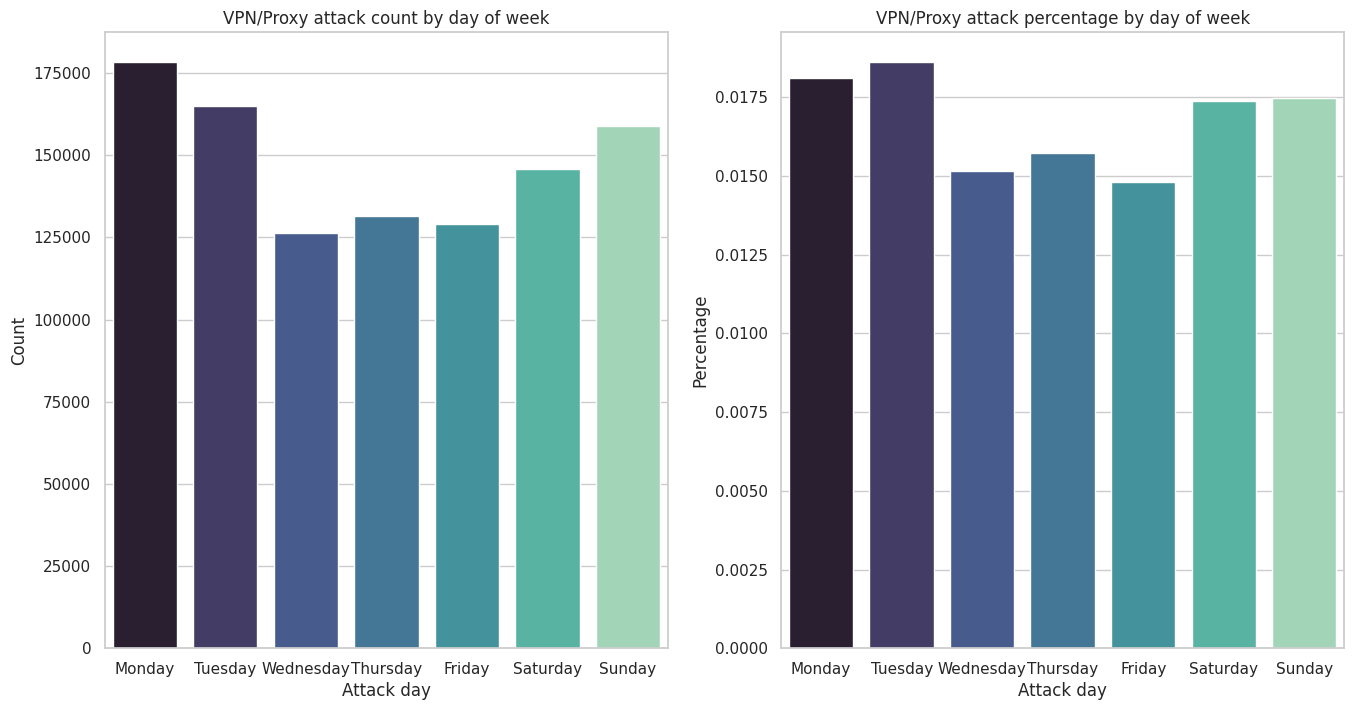

In [ ]:
f, (ax4_1, ax4_2) = plt.subplots(ncols=2, figsize=(16,8))

sns.barplot(plot4_df1,

            x='attack_day',
            y='label',
            log=False,
            palette='mako',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            ax=ax4_1
            )

sns.barplot(plot4_df2,
            x='attack_day',
            y='label',
            log=False,
            palette='mako',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            ax=ax4_2
            )

ax4_1.set_title("VPN/Proxy attack count by day of week")
ax4_1.set_xlabel("Attack day")
ax4_1.set_ylabel("Count")

ax4_2.set_title("VPN/Proxy attack percentage by day of week")
ax4_2.set_xlabel("Attack day")
ax4_2.set_ylabel("Percentage")

f.savefig('visu4.png', dpi=200)

plt.show

In [ ]:
del plot4_df1, plot4_df2
gc.collect()

15306

## Insights
---

- Tanto en cantidad absoluta como en porcentajes se observa claramente que hay más ataques de VPN/Proxy entre sábado y martes

# Plot 5: ataques por hora

In [12]:
plot5_df = raw_train[['attack_time', 'label']]
plot5_df['attack_hour'] = plot5_df['attack_time'].dt.hour
plot5_df['weekday'] = plot5_df['attack_time'].dt.dayofweek.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
plot5_df.drop('attack_time', axis=1, inplace=True)
plot5_df.sample(5)

,label,attack_hour,weekday
46868966,0,11,Weekend
50784261,0,13,Weekday
26368559,0,13,Weekend
29282384,0,1,Weekday
32527447,0,1,Weekend


In [13]:
plot5_df1 = plot5_df[plot5_df['label'] == 1].groupby(['attack_hour', 'weekday'])['label'].sum().unstack().reset_index()
plot5_df2 = plot5_df.groupby(['attack_hour', 'weekday'])['label'].mean().unstack().reset_index()

del plot5_df
gc.collect()

55

In [15]:
plot5_df1


weekday,attack_hour,Weekday,Weekend
0,0,25393,13739
1,1,25549,12615
2,2,28655,14059
3,3,30397,14770
4,4,28703,13139
5,5,29804,12624
6,6,32947,12724
7,7,36854,14677
8,8,38611,14357
9,9,38612,12673


<function matplotlib.pyplot.show(close=None, block=None)>

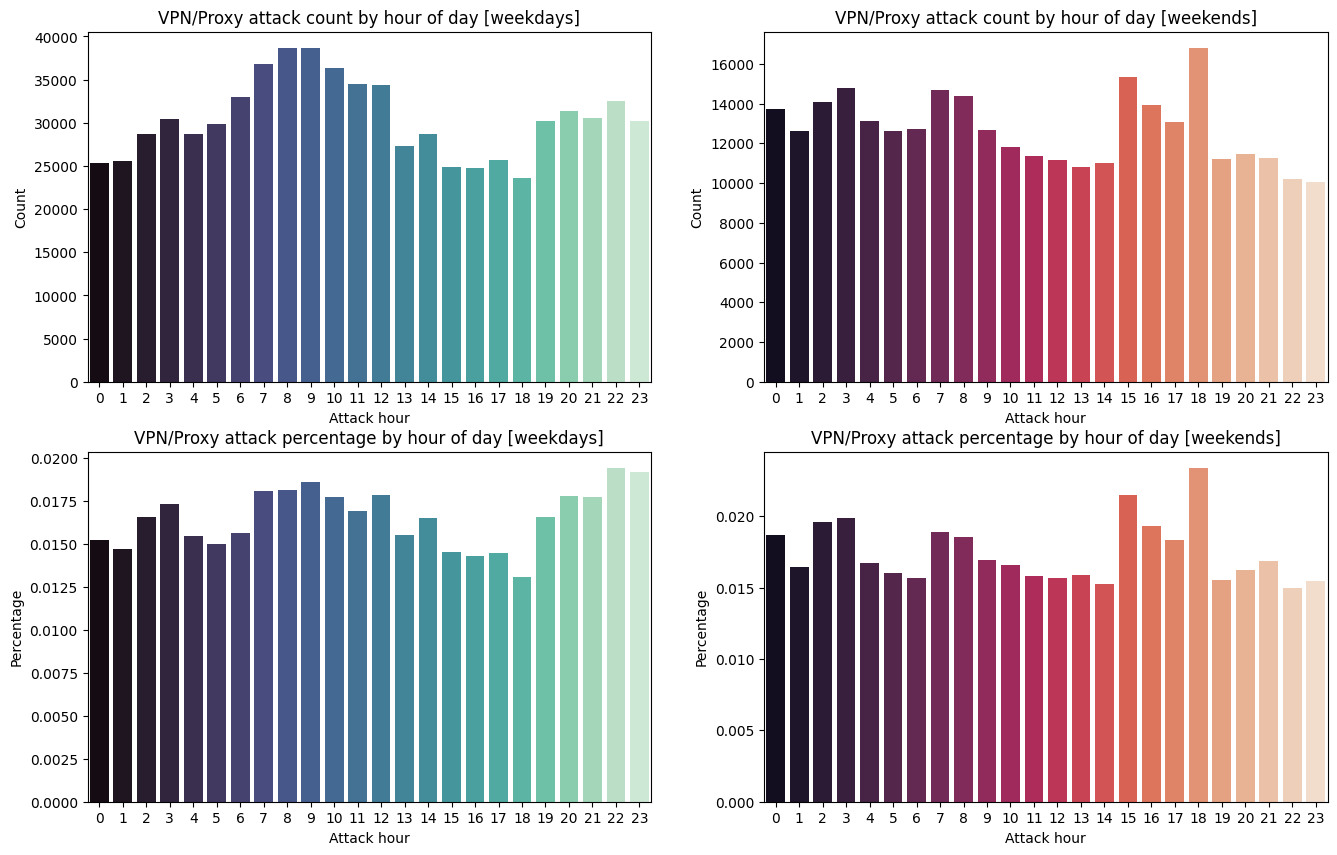

In [25]:
f, (ax4_1, ax4_2) = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

sns.barplot(plot5_df1,
            x='attack_hour',
            y='Weekday',
            log=False,
            palette='mako',
            ax=ax4_1[0]
            )

sns.barplot(plot5_df2,
            x='attack_hour',
            y='Weekday',
            log=False,
            palette='mako',
            ax=ax4_2[0]
            )

sns.barplot(plot5_df1,
            x='attack_hour',
            y='Weekend',
            log=False,
            palette='rocket',
            ax=ax4_1[1]
            )

sns.barplot(plot5_df2,
            x='attack_hour',
            y='Weekend',
            log=False,
            palette='rocket',
            ax=ax4_2[1]
            )

ax4_1[0].set_title("VPN/Proxy attack count by hour of day [weekdays]")
ax4_1[0].set_xlabel("Attack hour")
ax4_1[0].set_ylabel("Count")

ax4_2[0].set_title("VPN/Proxy attack percentage by hour of day [weekdays]")
ax4_2[0].set_xlabel("Attack hour")
ax4_2[0].set_ylabel("Percentage")

ax4_1[1].set_title("VPN/Proxy attack count by hour of day [weekends]")
ax4_1[1].set_xlabel("Attack hour")
ax4_1[1].set_ylabel("Count")

ax4_2[1].set_title("VPN/Proxy attack percentage by hour of day [weekends]")
ax4_2[1].set_xlabel("Attack hour")
ax4_2[1].set_ylabel("Percentage")

f.savefig('visu5.png', dpi=200)

plt.show

In [ ]:
del plot5_df1, plot5_df2
gc.collect()

8065

## Insights
---

- Es muy notable la diferencia de distribución entre fin de semana y entre semana
- Lo más interesante es los picos a la mañana y a la noche entre semana, y a la tarde los findes


# Plot 6/6: marginales de continentes

In [ ]:
continents = {
    'US': 'NA', 'DE': 'EU', 'SG': 'AS', 'CN': 'AS', 'NL': 'EU', 'GI': 'EU',
    'FR': 'EU', 'IN': 'AS', 'GB': 'EU', 'RU': 'EU', 'CA': 'NA', 'GM': 'AF',
    'VN': 'AS', 'BR': 'SA', 'ID': 'AS', 'HK': 'AS', 'IT': 'EU', 'GN': 'AF',
    'AU': 'OC', 'JP': 'AS', 'KR': 'AS', 'UA': 'EU', 'SE': 'EU', 'GP': 'NA',
    'FI': 'EU', 'BG': 'EU', 'IR': 'AS', 'TR': 'AS', 'BD': 'AS', 'PH': 'AS',
    'ES': 'EU', 'SK': 'EU', 'TH': 'AS', 'PL': 'EU', 'AR': 'SA', 'GQ': 'AF',
    'LU': 'EU', 'CH': 'EU', 'PK': 'AS', 'MX': 'NA', 'RO': 'EU', 'GU': 'NA',
    'ZA': 'AF', 'BE': 'EU', 'NO': 'EU', 'RS': 'EU', 'TW': 'AS', 'GY': 'SA',
    'AT': 'EU', 'AE': 'AS', 'LV': 'EU', 'MY': 'AS', 'PT': 'EU', 'KM': 'AF',
    'CZ': 'EU', 'CO': 'SA', 'AZ': 'AS', 'DK': 'EU', 'LT': 'EU', 'LC': 'NA',
    'IL': 'AS', 'KH': 'AS', 'IE': 'EU', 'GR': 'EU', 'VE': 'SA', 'ML': 'AF',
    'PE': 'SA', 'SA': 'AS', 'KE': 'AF', 'CL': 'SA', 'BF': 'AF', 'MW': 'AF',
    'MA': 'AF', 'MD': 'EU', 'CI': 'AF', 'MN': 'AS', 'HR': 'EU', 'NA': 'AF',
    'KZ': 'AS', 'EG': 'AF', 'ET': 'AF', 'MC': 'EU', 'MU': 'AF', 'RE': 'AF',
    'TN': 'AF', 'DO': 'NA', 'NP': 'AS', 'PA': 'CA', 'BM': 'NA', 'SD': 'AF',
    'GH': 'AF', 'HU': 'EU', 'EE': 'EU', 'BY': 'EU', 'BA': 'EU', 'SX': 'NA',
    'DZ': 'AF', 'MK': 'EU', 'GE': 'AS', 'EC': 'SA', 'IQ': 'AS', 'TC': 'NA',
    'LK': 'AS', 'NG': 'AF', 'AM': 'EU', 'AL': 'EU', 'BW': 'AF', 'YE': 'AS',
    'LB': 'AS', 'AO': 'AF', 'NZ': 'OC', 'JO': 'AS', 'BO': 'SA', 'NC': 'OC',
    'TZ': 'AF', 'PY': 'SA', 'GT': 'CA', 'HN': 'CA', 'BN': 'AS', 'SM': 'EU',
    'MZ': 'AF', 'UZ': 'AS', 'QA': 'AS', 'CY': 'EU', 'LA': 'AS', 'SI': 'EU',
    'OM': 'AS', 'KW': 'AS', 'UG': 'AF', 'ME': 'EU', 'SV': 'CA',
    'JM': 'NA', 'BH': 'AS', 'UY': 'SA', 'BB': 'NA', 'BQ': 'SA',
    'RW': 'AF', 'PF': 'OC', 'CR': 'CA', 'MV': 'AS', 'PS': 'AS',
    'LY': 'AF', 'SN': 'AF', 'ZW': 'AF', 'TT': 'NA', 'XK': 'EU',
    'IS': 'EU', 'MT': 'EU', 'MM': 'AS', 'KG': 'AS', 'BI': 'AF', 'LI': 'EU',
    'WS': 'OC', 'BZ': 'CA', 'PR': 'NA', 'TG': 'AF', 'BS': 'NA',
    'NI': 'CA', 'SC': 'AF', 'ZM': 'AF', 'CM': 'AF', 'MR': 'AF',
    'VG': 'NA', 'CW': 'NA', 'SO': 'AF', 'MG': 'AF', 'DM': 'NA',
    'AF': 'AS', 'SY': 'AS', 'CD': 'AF', 'CV': 'AF', 'SS': 'AF', 'AG': 'NA',
    'SR': 'SA', 'TJ': 'AS', 'HT': 'NA', 'BJ': 'AF', 'AD': 'EU',
    'DJ': 'AF', 'IM': 'EU', 'MO': 'AS', 'GG': 'EU', 'GF': 'SA',
    'BT': 'AS', 'ER': 'AF', 'NE': 'AF', 'FO': 'EU', 'GD': 'NA',
    'SB': 'OC', 'SZ': 'AF', 'KN': 'NA', 'KY': 'NA', 'FM': 'OC',
    'LS': 'AF', 'VC': 'NA', 'CX': 'OC', 'GW': 'AF', 'PG': 'OC',
    'PM': 'NA', 'GL': 'NA', 'SH': 'AF', 'ST': 'AF', 'GA': 'AF',
    'VI': 'NA', 'LR': 'AF', 'TL': 'AS', 'CG': 'AF', 'MP': 'OC',
    'KP': 'AS', 'CU': 'CA', 'AI': 'NA', 'SL': 'AF', 'AW': 'NA',
    'FJ': 'OC', 'MQ': 'NA', 'JE': 'EU', 'GG': 'EU'
}

In [ ]:
plot6_df = raw_train[['attacker_country', 'watcher_country', 'label']]
plot6_df['watcher_country'] = plot6_df['watcher_country'].apply(lambda x: continents[x]).astype('category')
plot6_df['attacker_country'] = plot6_df['attacker_country'].apply(lambda x: continents[x]).astype('category')

In [ ]:
plot6_df1 = plot6_df[['watcher_country', 'label']].groupby('watcher_country')['label'].mean().reset_index()
plot6_df2 = plot6_df[['attacker_country', 'label']].groupby('attacker_country')['label'].mean().reset_index()

del plot6_df
gc.collect()

0

In [ ]:
plot6_df1

,watcher_country,label
0,AF,0.01
1,AS,0.02
2,CA,0.02
3,EU,0.02
4,NA,0.02
5,OC,0.01
6,SA,0.02


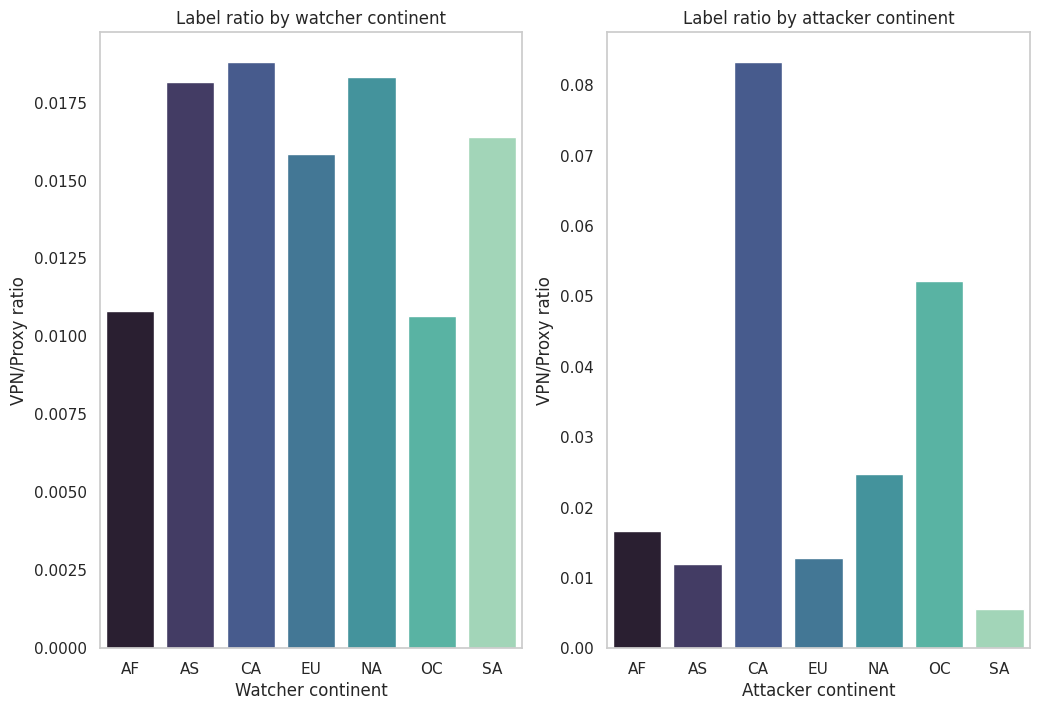

In [ ]:
f, (ax6_1, ax6_2) = plt.subplots(ncols=2, figsize=(12,8))

plt.style.use('default')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format

sns.barplot(plot6_df1,
            x='watcher_country',
            y='label',
            palette="mako",
            ax=ax6_1,
            )
ax6_1.set_title("Label ratio by watcher continent")
ax6_1.set_xlabel("Watcher continent")
ax6_1.set_ylabel("VPN/Proxy ratio")
ax6_1.grid(False)

sns.barplot(plot6_df2,
            x='attacker_country',
            y='label',
            palette="mako",
            ax=ax6_2,
            )
ax6_2.set_title("Label ratio by attacker continent")
ax6_2.set_xlabel("Attacker continent")
ax6_2.set_ylabel("VPN/Proxy ratio")
ax6_2.grid(False)

f.savefig('visu6.png', dpi=200)

In [ ]:
del plot6_df1, plot6_df2, continents
gc.collect()

11785

### Insights
---
- Los porcentajes para continentes son bastante dispares en el caso de los atacantes
- Va bastante de la mano con lo que se veía en el heatmap